In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
Define I/O info
"""
# path to input directory
inDIR = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_f = '2017_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = '/mnt/c/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if not os.path.exists(os.path.join(outDIR, 'seas/')):
    os.mkdir(os.path.join(outDIR, 'seas/'))
    
if not os.path.exists(os.path.join(outDIR, 'results_tables/')):
    os.mkdir(os.path.join(outDIR, 'results_tables/'))

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_full = pd.read_csv(os.path.join(inDIR, griddata_f))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
dCorner         float64
TPC_c            object
dtype: object

In [4]:
df_wkly_grid_full

,index_id,mod_data,week,Pasture,Steer_ID,UTM_X,UTM_Y,grazing_secs,TPC,dFence,dTank,PC_dmt,PC_pct,PC_div,Biomass,CP,DOM,dCorner,TPC_c
0,0,test,19,24W,3770_D1_2017,522435.0,4519545.0,170.19232,2.0,0.0,750.0,Bare_veg,0.907778,0.376950,697.27203,10.875054,66.504900,22.575673,Lowlands
1,1,test,19,24W,3770_D1_2017,522435.0,4519515.0,0.00000,2.0,0.0,750.0,C4,0.467778,1.168814,644.40540,10.879135,66.347600,44.300942,Lowlands
2,2,test,19,24W,3770_D1_2017,522435.0,4519485.0,0.00000,2.0,0.0,752.0,C4,0.737778,0.851199,608.77826,10.839300,66.318970,72.218321,Lowlands
3,3,test,19,24W,3770_D1_2017,522435.0,4519455.0,0.00000,2.0,0.0,755.0,C4,0.663333,0.842480,711.02590,10.861595,66.356450,101.333106,Lowlands
4,4,test,19,24W,3770_D1_2017,522435.0,4519425.0,0.00000,2.0,0.0,759.0,C4,0.583333,0.986706,774.49740,10.880774,66.341040,130.848427,Lowlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283514,1638,test,39,31E,4598_D3_2017,525885.0,4514865.0,0.00000,9.0,0.0,480.0,C4,0.766667,0.584385,629.16656,6.626579,58.771763,135.874582,Highlands
283515,1639,test,39,31E,4598_D3_2017,525885.0,4514835.0,0.00000,6.0,0.0,510.0,C4,0.902222,0.349959,648.41077,6.615527,58.818707,106.505280,Open Slopes
283516,1640,test,39,31E,4598_D3_2017,525885.0,4514805.0,0.00000,6.0,0.0,540.0,C4,0.614444,0.884778,662.57920,6.637170,58.623493,77.619891,Open Slopes
283517,1641,test,39,31E,4598_D3_2017,525885.0,4514775.0,0.00000,5.0,0.0,570.0,Bare_veg,0.622222,0.745489,617.94530,6.731618,59.289543,50.063162,Flat Plains


In [5]:
"""
Add season to dataset based on week
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])

'Number of grazing values > 10,000 = 2'

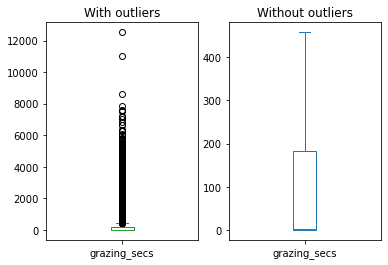

In [6]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > 10000])))

In [7]:
# mask grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full.loc[df_wkly_grid_full['grazing_secs'] > max_graze_secs, 'grazing_secs'] = np.nan

In [8]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]

In [9]:
"""
Flag and remove any outliers beyond last 60-sec bin with only one pixel
"""

def flag_graze_outliers(x, bins=np.arange(-5, 10000, 60)):
    groups = x.groupby(pd.cut(x, bins, include_lowest=False))
    one_bins = bins[:-1][(groups.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 60, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    return (x >= last_one_bin).astype('int')
    
df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    198.000000
mean       5.782828
std        2.558614
min        2.000000
25%        4.000000
50%        5.000000
75%        7.000000
max       13.000000
Name: grazing_secs_outlier, dtype: float64

In [10]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [11]:
"""
Calculate total weekly grazing seconds per steer-week to use as offset to account for missing data
"""
# get the sum total of grazing seconds for each steer-week
df_wkly_grid_full['grazing_wkly_sum'] = df_wkly_grid_full.groupby(['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('sum')

In [12]:
"""
Calculate grazing frequency relative to expected with perfectly even grazing
"""
df_wkly_grid_full['grazing_rel_freq'] = df_wkly_grid_full['grazing_secs'] / (df_wkly_grid_full['grazing_wkly_sum'] / 
                                                                             df_wkly_grid_full.groupby(
                                                                                 ['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('count'))
df_wkly_grid_full['grazing_rel_freq'].describe()

count    279839.000000
mean          1.000000
std           1.752067
min           0.000000
25%           0.000000
50%           0.000000
75%           1.360538
max          47.136436
Name: grazing_rel_freq, dtype: float64

In [13]:
"""
Scale variables if desired
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scale_vars=False
if scale_vars:
    for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
        for past in df_wkly_grid_full['Pasture'].unique():
            for wk in df_wkly_grid_full[df_wkly_grid_full['Pasture'] == past]['week'].unique():
                scaler.fit(df_wkly_grid_full.loc[(df_wkly_grid_full['week'] == wk) &
                                                 (df_wkly_grid_full['Pasture'] == past), c].values.reshape(-1, 1))
                df_wkly_grid_full.loc[(df_wkly_grid_full['week'] == wk) &
                                                 (df_wkly_grid_full['Pasture'] == past), c] = scaler.transform(
                    df_wkly_grid_full.loc[(df_wkly_grid_full['week'] == wk) &
                                                 (df_wkly_grid_full['Pasture'] == past), c].values.reshape(-1, 1)).flatten()
#for c in ['dFence', 'dTank', 'Biomass', 'CP', 'PC_div']:
#    df_wkly_grid_full.loc[:, c] = df_wkly_grid_full.groupby(['season'])[c].transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
    #scaler.fit_transform(df_wkly_grid_full[c].values.reshape(-1, 1)).flatten()#.transform(
#        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

In [14]:
df = df_wkly_grid_full.groupby(['Pasture', 'week', 'UTM_X', 'UTM_Y']).mean().reset_index()

In [58]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [146]:
df_corr = pd.DataFrame(columns=['Pasture', 'wk', 'lag', 'grz_grz_cor', 'bm_grz_cor', 'cp_grz_cor'])
#past = '31E'
for past in tqdm(df['Pasture'].unique()):
    df_sub = df[df['Pasture'] == past]
    df_sub = df_sub.set_index(['UTM_X', 'UTM_Y'])[df_sub.groupby(['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['week'].unique())].reset_index()
    #df_sub['grazing_rel_freq_dm'] = df_sub['grazing_rel_freq'] - df_sub['grazing_rel_freq'].mean()
    for c in ['grazing_rel_freq', 'Biomass', 'CP', 'PC_div']:
        df_sub[c] = scaler.fit_transform(df_sub[c].values.reshape(-1, 1)).flatten()
    idx = 0
    for wk in df_sub['week'].unique():
        for wk2 in df_sub[df_sub['week'] < wk]['week'].unique():
            lag_i = wk2-wk
            grz_grz_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], df_sub[df_sub['week'] == wk2]['grazing_rel_freq'])
            bm_grz_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], df_sub[df_sub['week'] == wk2]['Biomass'])
            cp_grz_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], df_sub[df_sub['week'] == wk2]['CP'])
            grz_bm_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk2]['grazing_rel_freq'], df_sub[df_sub['week'] == wk]['Biomass'])
            grz_cp_corr_tmp = np.corrcoef(df_sub[df_sub['week'] == wk2]['grazing_rel_freq'], df_sub[df_sub['week'] == wk]['CP'])
            
            if lag_i != 0:
                x_bm_list = []
                x_cp_list = []
                x_grz_list = []
                for wk_i in range(min(wk2, wk), max(wk2, wk)):
                    grz_vals_tmp = df_sub[df_sub['week'] == wk_i]['grazing_rel_freq'].values
                    bm_vals_tmp = df_sub[df_sub['week'] == wk_i]['Biomass'].values
                    cp_vals_tmp = df_sub[df_sub['week'] == wk_i]['CP'].values
                    if len(grz_vals_tmp) > 0:
                        x_grz_list.append(np.array(grz_vals_tmp))
                    if len(bm_vals_tmp) > 0:
                        x_bm_list.append(np.array(bm_vals_tmp))
                    if len(cp_vals_tmp) > 0:
                        x_cp_list.append(np.array(cp_vals_tmp))
                        
                x_grz = np.array(x_grz_list).transpose()
                x_grz = add_constant(x_grz)
                f_grz_bm = sm.RLM(df_sub[df_sub['week'] == wk]['Biomass'], x_grz, hasconst=True).fit()
                f_grz_cp = sm.RLM(df_sub[df_sub['week'] == wk]['CP'], x_grz, hasconst=True).fit()
                
                x_bm = np.array(x_bm_list).transpose()
                x_bm = add_constant(x_bm)
                f_bm = sm.RLM(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], x_bm, hasconst=True).fit()
                
                x_cp = np.array(x_cp_list).transpose()
                x_cp = add_constant(x_cp)
                f_cp = sm.RLM(df_sub[df_sub['week'] == wk]['grazing_rel_freq'], x_cp, hasconst=True).fit()
                
                grz_bm_lr_coef_tmp = sum(f_grz_bm.params[1:])
                grz_cp_lr_coef_tmp = sum(f_grz_cp.params[1:])
                bm_lr_coef_tmp = sum(f_bm.params[1:])
                cp_lr_coef_tmp = sum(f_cp.params[1:])
                
                if lag_i < 0:
                    grz_bm_sr_coef_tmp = f_grz_bm.params[1]
                    grz_cp_sr_coef_tmp = f_grz_cp.params[1]
                    bm_sr_coef_tmp = f_bm.params[1]
                    cp_sr_coef_tmp = f_cp.params[1]
                if lag_i > 0:
                    grz_bm_sr_coef_tmp = f_grz_bm.params[-1]
                    grz_cp_sr_coef_tmp = f_grz_cp.params[-1]
                    bm_sr_coef_tmp = f_bm.params[-1]
                    cp_sr_coef_tmp = f_cp.params[-1]
            else:
                bm_coef_tmp = np.nan
            df_tmp = pd.DataFrame(data={'Pasture': past,
                                        'week': wk,
                                        'lag': lag_i,
                                        'grz_grz_cor': grz_grz_corr_tmp[0, 1],
                                        'bm_grz_cor': bm_grz_corr_tmp[0, 1],
                                        'cp_grz_cor': cp_grz_corr_tmp[0, 1],
                                        'grz_bm_cor': grz_bm_corr_tmp[0, 1],
                                        'grz_cp_cor': grz_cp_corr_tmp[0, 1],
                                        'grz_bm_lr_coef': grz_bm_lr_coef_tmp,
                                        'grz_cp_lr_coef': grz_cp_lr_coef_tmp,
                                        'bm_lr_coef': bm_lr_coef_tmp,
                                        'cp_lr_coef': cp_lr_coef_tmp,
                                        'grz_bm_sr_coef': grz_bm_sr_coef_tmp,
                                        'grz_cp_sr_coef': grz_cp_sr_coef_tmp,
                                        'bm_sr_coef': bm_sr_coef_tmp,
                                        'cp_sr_coef': cp_sr_coef_tmp},
                                  index=[idx])
            df_corr = pd.concat([df_corr, df_tmp])
            idx += 1

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_300/3060771770.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub = df_sub.set_index(['UTM_X', 'UTM_Y'])[df_sub.groupby(['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['week'].unique())].reset_index()
/tmp/ipykernel_300/3060771770.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub = df_sub.set_index(['UTM_X', 'UTM_Y'])[df_sub.groupby(['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['week'].unique())].reset_index()
/tmp/ipykernel_300/3060771770.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub = df_sub.set_index(['UTM_X', 'UTM_Y'])[df_sub.groupby(['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['week'].unique())].reset_index()
/tmp/ipykernel_300/3060771770.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub = df_sub.set_index(['UTM_X', 'UTM_Y'])[df_sub.groupby(['UTM_X', 'UTM_Y'])['week'].count() == len(df_sub['

In [147]:
df_corr['season'] = df_corr['week'].apply(lambda x: season_func(x))
df_corr.loc[df_corr['lag'] == 0, 'grz_grz_cor'] = np.nan

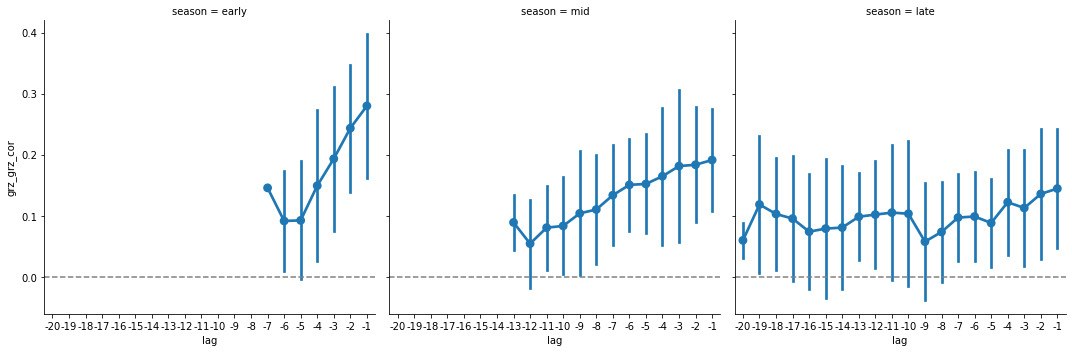

In [148]:
g = sns.catplot(x='lag', y='grz_grz_cor', kind='point', col='season', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

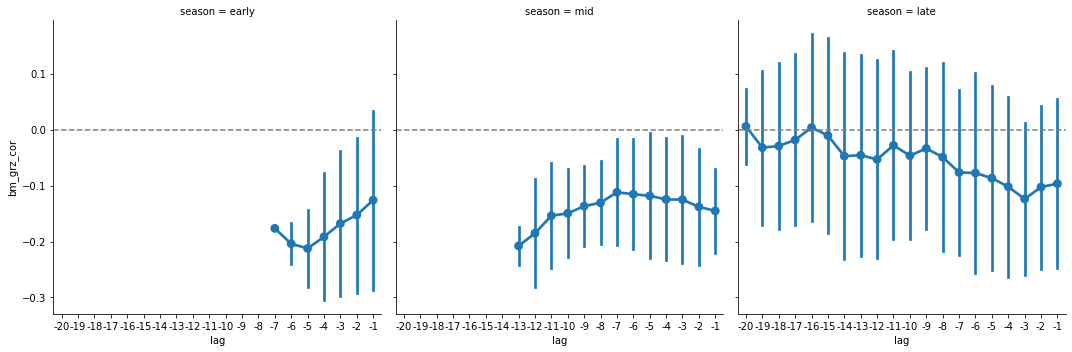

In [149]:
g = sns.catplot(x='lag', y='bm_grz_cor', col='season', kind='point', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

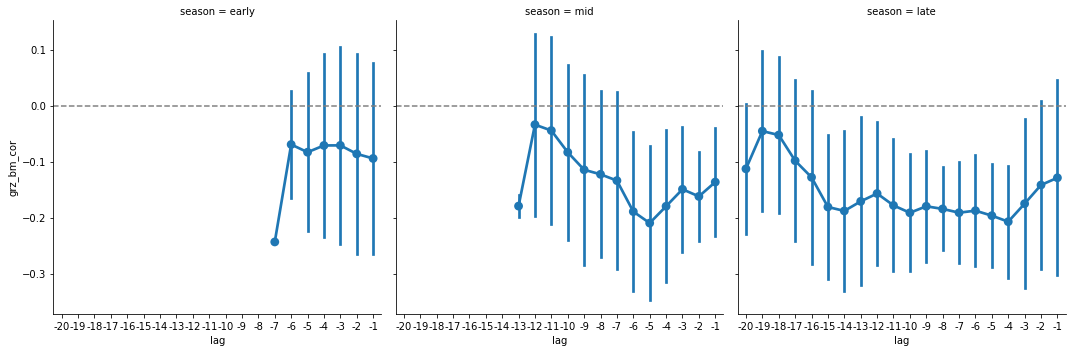

In [150]:
g = sns.catplot(x='lag', y='grz_bm_cor', col='season', kind='point', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

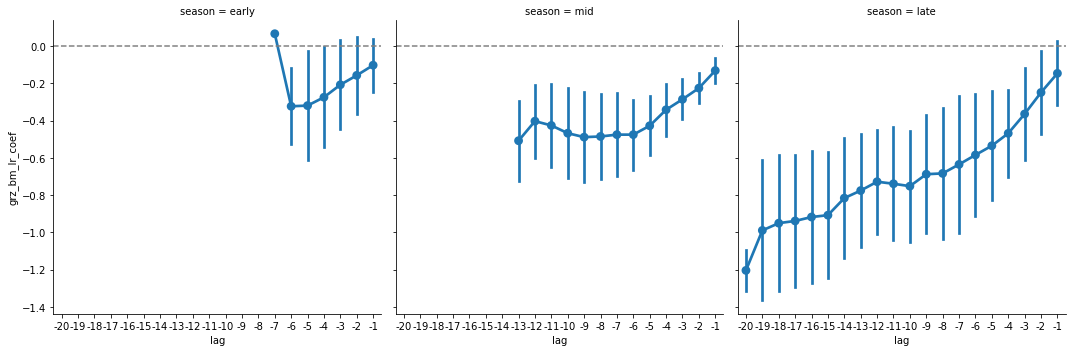

In [152]:
g = sns.catplot(x='lag', y='grz_bm_lr_coef', col='season', kind='point', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

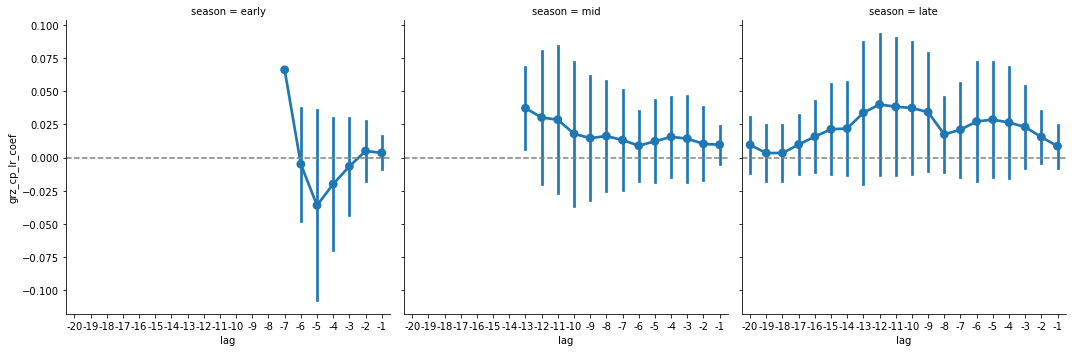

In [153]:
g = sns.catplot(x='lag', y='grz_cp_lr_coef', col='season', kind='point', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

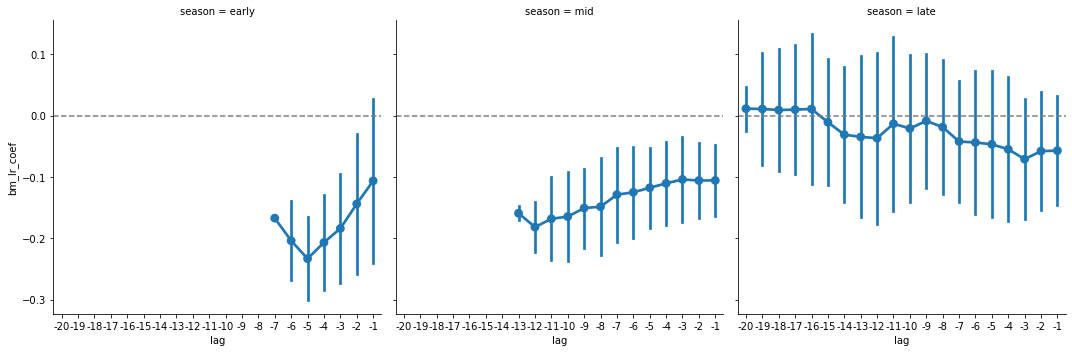

In [154]:
g = sns.catplot(x='lag', y='bm_lr_coef', col='season', kind='point', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

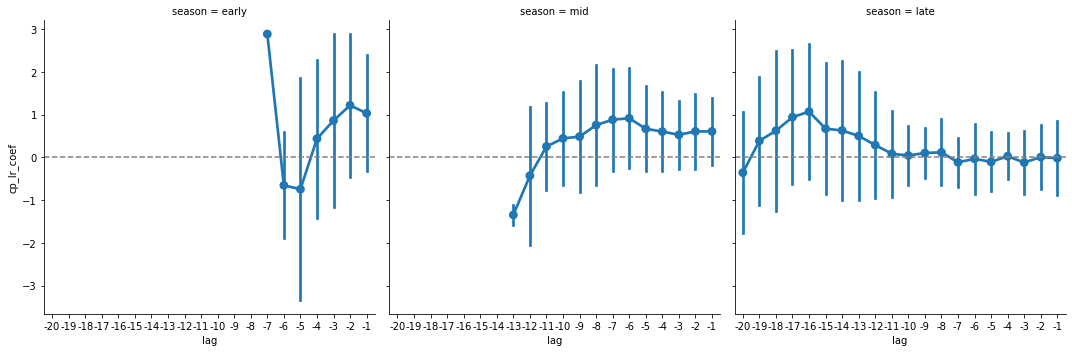

In [158]:
g = sns.catplot(x='lag', y='cp_lr_coef', col='season', kind='point', data=df_corr, ci='sd')
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')

In [119]:
df_sub['week'].unique()

array([21, 22, 23, 24, 25, 28, 29, 30, 31, 33, 34, 37, 38, 39])

In [127]:
wk = 39
wk2 = 30
y = df_sub[df_sub['week'] == wk]['Biomass'].values
#y = y - np.mean(y)
x1_list = []
for wk_i in range(wk2, wk):
    vals = df_sub[df_sub['week'] == wk_i]['grazing_rel_freq'].values
    if len(vals) != 0:
        x1_list.append(np.array(vals))
x1 = np.array(x1_list).transpose()
#x1 = x1 - np.mean(x1)
x1 = add_constant(x1)
x2 = df_sub[df_sub['week'] == wk2]['Biomass'].values
f1 = sm.RLM(y, x1, hasconst=True).fit()
f2 = OLS(x2, x1).fit()
pcorr = np.corrcoef(f1.resid, f2.resid)[0, 1]
#yule_walker(x, k, method='unbiased')#[0][-1]

In [130]:
sum(f1.params[1:])

-0.48326663345482324

In [129]:
f1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                 1349
Model:                            RLM   Df Residuals:                     1342
Method:                          IRLS   Df Model:                            6
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 29 Dec 2022                                         
Time:                        12:11:06                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1484      0.031     -4.751      0.000      -0.210      -0.087
x1            -0.2588      0.034     -7.703      0.000      -0.325      -0.193
x2            -0.2566      0.030     -8.584      0.000      -0.315      -0.198
x3             0.0131      0.032      0.409      0.683      -0.050       0.076
x4             0.0337      0.030      1.135      0.256      -0.025       0.092
x5            -0.0154      0.036     -0.430      0.667      -0.086       0.055
x6             0.0008      0.030      0.026      0.979      -0.058       0.059
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [95]:
np.corrcoef(y, x2)

array([[ 1.        , -0.03485208],
       [-0.03485208,  1.        ]])

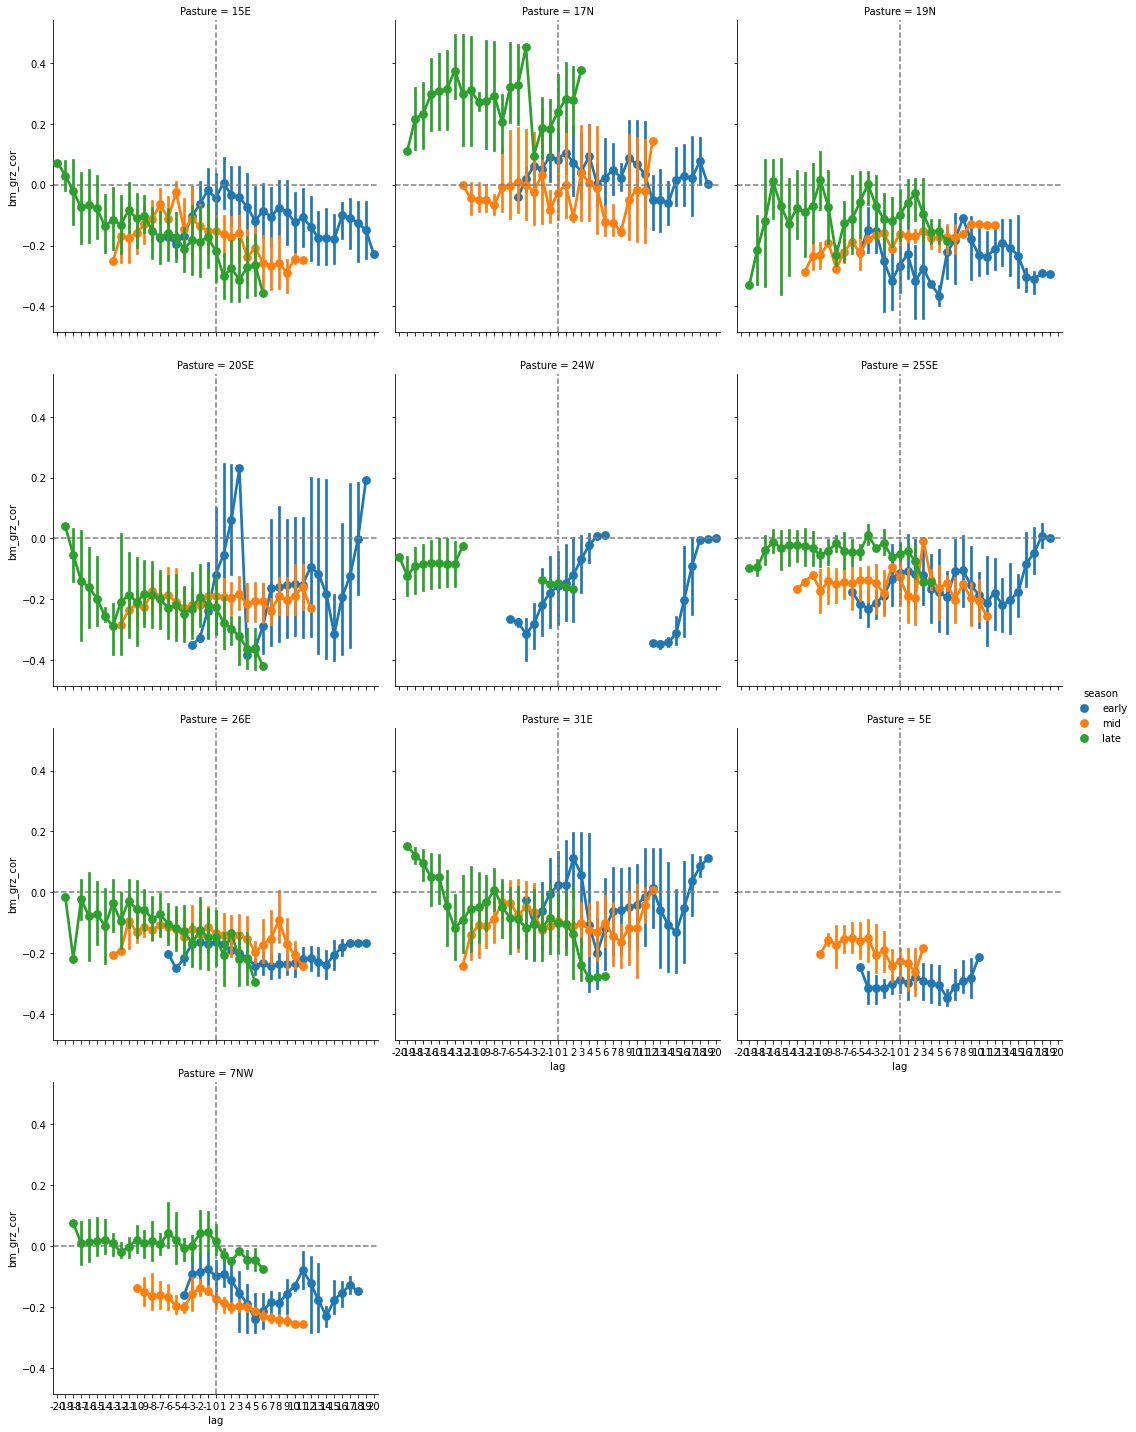

In [22]:
g = sns.catplot(x='lag', y='bm_grz_cor', hue='season', col='Pasture', col_wrap=3, kind='point', data=df_corr)
for ax in g.axes.flatten():
    ax.axhline(y=0, linestyle='dashed', color='grey')
    ax.axvline(x=20, linestyle='dashed', color='grey')